Prep data for the LSTM:
1. all data


In [ ]:
## using the neuralhydrology package
## 1: prep the data according to the nh standard
import pandas as pd
import xarray as xr
from fos import util
from fos.data import snotelmeta 
import datetime
import os
import numpy as np
from fos.util import get_wrf_data_points

## 
def wrfread(datadir, gcm, exp, variant, domain, var):
    modeldir = datadir + gcm + '/postprocess/'+domain + '/'
    all_files = sorted(os.listdir(modeldir))
    read_files = []
    for ii in all_files:
        if (
            ii.startswith(var + ".")
            and model in ii
            and variant in ii
            and domain in ii
        ):
            if domain in ii:
                read_files.append(os.path.join(modeldir, str(ii)))
    assert len(read_files) > 0, f"No matching files found in {modeldir}"

    del all_files

    data = xr.open_mfdataset(read_files, combine="by_coords")
    var_read = data.variables[var]

    dates = []
    for val in data["day"].data:
        try:
            dates.append(datetime.datetime.strptime(str(val)[0:-2], "%Y%m%d").date())
        except ValueError:
            dates.append(datetime.datetime(int(str(val)[0:4]), int(str(val)[4:6]), 28))


    var_read = xr.DataArray(var_read, dims=["day", "lat2d", "lon2d"])
    var_read["day"] = dates
    return var_read

## load data  
var = 'snow'
modeldir = '/glade/campaign/uwyo/wyom0112/postprocess/'
model = 'ukesm1-0-ll'
variant = 'r2i1p1f2'
domain = 'd02'
basedir = '/glade/u/home/mcowherd/'
projectdir = basedir + 'fos-data/'
snoteldir = projectdir + 'snoteldata/'
wrfdir = '/glade/campaign/uwyo/wyom0112/postprocess/'
wrfcoorddir = projectdir 
domain = "d02"

## LOAD DATA ## 
mod_historical = model +'_'+ variant + '_historical_bc'
mod_future = model +'_' + variant+ '_ssp370_bc'
gcm = mod_historical
date_start_pd, date_end_pd = [1980, 1, 1], [2013, 12, 31]  # 30 years, historical
exp = "hist"
var_wrf = wrfread(modeldir, gcm, exp, variant, domain, var)
var_wrf = util.screen_times_wrf(var_wrf, date_start_pd, date_end_pd)

# future dates
date_start_pd, date_end_pd = [2014, 1, 1], [2100, 12, 31]
gcm = mod_future
model = "ssp370"
var_wrf_ssp370 = wrfread(modeldir, gcm, model, variant, domain, var)
var_wrf_ssp370 = util.screen_times_wrf(var_wrf_ssp370, date_start_pd, date_end_pd)

wrfdata = [var_wrf, var_wrf_ssp370]

coords = util.get_coords(wrfcoorddir+'/wrf_coordinates')

lon_wrf = coords['lon2d']
lat_wrf = coords['lat2d']


wrf_snow_data = []
for i, entry in snotelmeta[100:102].iterrows():
    pt = [entry.lon, entry.lat]
    dis = ((pt[0]-lon_wrf[:].data)**2+(pt[1]-lat_wrf[:].data)**2)**0.5
    ind = np.unravel_index(dis.argmin(), dis.shape)
    j = int(ind[0])
    k = int(ind[1])
    wrfts = get_wrf_data_points(wrfdata, j, k)
    wrf_snow_data.append(wrfts)
    
N = len(wrf_snow_data[0])
index = pd.date_range('1980-01-01', periods=N, freq='D')
data = {'SNOTEL_SWE':wrf_snow_data[0]}
forcing_data = pd.DataFrame(data, index=index)
true_SWE = pd.DataFrame({'SWE': wrf_snow_data[1]}, index=index)


In [ ]:
from fos.models import snotel_value, snotel_with_offset, training_mean, lin_reg
from fos.util import partition_dataframe, make_time_lists
mods_and_params = [(snotel_value, {'vars': ['SWE']}), 
                   (snotel_with_offset,  {'vars': ['SWE']}),
                   (training_mean,  {'vars': ['SWE']}),
                   (lin_reg,  {'vars': ['SWE'], 'fvars': ['SNOTEL_SWE']}),]

# Define start and stop dates for three time periods
time_periods = {'train': ('1980-01-01','2000-01-01'),
           'validation': ('2000-01-01', '2020-01-01'),
           'test': ('2020-01-01','2090-01-01')}


forcing_split = partition_dataframe(forcing_data, time_periods)
obs_split = partition_dataframe(true_SWE, time_periods)
dates_lists = make_time_lists(time_periods)


num = 123456789 ## get it from the thing
datadir = '/glade/u/home/mcowherd/nh-WRF/'


forcing_head = ['Year','Month','Day','Hr', 'SNOTEL_SWE']
## usgs txt fmt = 123456789 1980 01 01 VALUE ## 
forcing_dir = datadir + '/basin_mean_forcing/nldas/'
sf_dir = datadir + 'usgs_streamflow/'
forcing_of = forcing_dir + f'{num}_forcing.txt'
sf_of = sf_dir + f'{num}_streamflow.txt'
nc_of = datadir + f'time_series/{num}.nc'

df = forcing_data.copy()
# Save DataFrame to tab-delimited text file with year, month, date, and value in separate columns
df.reset_index(inplace=True)  # Reset index to use date as a column
df.rename(columns={'index': 'date'}, inplace=True)  # Rename index column to date
df['Year'] = df['date'].dt.year  # Extract year from date
df['Mnth'] = df['date'].dt.month  # Extract month from date
df['Day'] = df['date'].dt.day  # Extract day from date
df = df[['Year', 'Mnth', 'Day', 'SNOTEL_SWE']]  # Reorder columns
df.to_csv(forcing_of, sep='\t', index=False)  # Save DataFrame to tab-delimited text file

df = true_SWE.copy()
df.reset_index(inplace=True)  # Reset index to use date as a column
df.rename(columns={'index': 'date'}, inplace=True)  # Rename index column to da
basin = [num for i in range(len(df))]
df['basin'] = basin
df['Year'] = df['date'].dt.year  # Extract year from date
df['Mnth'] = df['date'].dt.month  # Extract month from date
df['Day'] = df['date'].dt.day  # Extract day from date
df = df[['basin', 'Year', 'Mnth', 'Day', 'SWE']]  # Reorder columns
df.to_csv(sf_of, sep='\t',header = False, index=False)  # Save DataFrame to tab-delimited text file


# Read in tab-delimited text file and create DataFrame
df = pd.read_csv(forcing_of, sep='\t', header=0, names=['year', 'month', 'day', 'SWE'])
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index('date')
df = df.drop(['year', 'month', 'day'], axis=1)

true_df = pd.read_csv(sf_of, sep='\t', header=0, names=['year', 'month', 'day', 'SNOTEL_SWE'])
true_df['date'] = pd.to_datetime(true_df[['year', 'month', 'day']])
true_df = true_df.set_index('date')
true_df = true_df.drop(['year', 'month', 'day'], axis=1)

df = pd.merge(df, true_df, on=['date'])
# Convert DataFrame to xarray Dataset and create 'date' coordinate from year, month, and day columns
ds = xr.Dataset.from_dataframe(df)

# Save xarray Dataset to netCDF file
ds.to_netcdf(nc_of)


prep data for LSTM:
    all points, just peak data

In [ ]:
dpath = "data/ukesm"
plotpath = "plots/dev"

from fos.util import setup_plot_style
from fos.util import memory
import os
import pandas as pd
## load data  
var = 'snow'
modeldir = '/glade/campaign/uwyo/wyom0112/postprocess/'
model = 'ukesm1-0-ll'
variant = 'r2i1p1f2'
domain = 'd02'
basedir = '/glade/u/home/mcowherd/'
projectdir = basedir + 'fos-data/'
snoteldir = projectdir + 'snoteldata/'
wrfdir = '/glade/campaign/uwyo/wyom0112/postprocess/'
wrfcoorddir = projectdir 
domain = "d02"
os.makedirs(plotpath, exist_ok=True)

In [1]:
## HELPERS
def read_csvs(dpath: str) -> pd.DataFrame:
  dfs = list()
  for filename in dpath:
      data = pd.read_csv(filename, index_col=None, header=0)
      data['pt'] = filename.stem.split('_')[-1]
      dfs.append(data)
  df = pd.concat(dfs, axis=0, ignore_index=True)
  df = df.rename(columns={'Unnamed: 0': 'wyear'})
  return df


@memory.cache
def get_data(dpath: str) -> pd.DataFrame:  
  basins = read_csvs(Path(dpath).glob("wrfb*.csv"))
  pts = read_csvs(Path(dpath).glob("wrfp*.csv"))
  combined_df = pd.merge(pts, basins, how='left', left_on=['pt', 'wyear'], right_on=['pt', 'wyear'], suffixes=('_pt', '_basin'))
  return combined_df

def savefig(name: str):
  plt.savefig(os.path.join(plotpath, name))


def plt_err_hist(dffield, xlabel, ylabel, title, fname):
  plt.clf()
  sns.histplot(dffield)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  savefig(fname)
  plt.show()

def plt_year_err(data, title, xlab, ylab, fname):
  plt.clf()
  mean_data = data.mean()
  std_data = data.std()
  mean_data.plot()
  plt.fill_between(mean_data.index, mean_data - std_data, mean_data +  std_data, color="b", alpha=0.2);
  plt.ylabel(ylab)
  plt.xlabel(xlab)
  plt.title(title)
  savefig(fname)
  plt.show()
  
def plot_relation(df, x, y, title, fname, c='wyear', colormap='viridis'):
  plt.clf()
  df.plot.scatter(x=x, y=y, c=c, colormap=colormap, title=title)
  plt.gca().axline((0, 0), slope=1)
  savefig(fname)
  plt.show()


NameError: name 'pd' is not defined

In [ ]:
# read in the data from dpath
df = get_data(dpath)
df.head()

orig_len = len(df)
# clean the data
df.dropna(inplace=True)
new_len = len(df)
print(f"dropped {orig_len - new_len}/{orig_len} rows with NaNs")


In [ ]:
from fos.data import huc6, in6s
import geopandas as gpd
snotelmeta = pd.read_csv(snoteldir + 'snotelmeta.csv')
huc6 = gpd.read_file(projectdir + 'spatialdata/huc6.shp')
huc8 = gpd.read_file(projectdir + 'spatialdata/huc8.shp')
snotel_gdf = gpd.GeoDataFrame(data = {'site_name':snotelmeta.site_name,
                                     'elev': snotelmeta.elev,
                                     'site_number':snotelmeta.site_number,
                                     'state':snotelmeta.state,
                                     'namestr':snotelmeta.namestr,
                                     'startdt':snotelmeta.startdt}, geometry = gpd.points_from_xy(snotelmeta.lon, snotelmeta.lat), crs = 'epsg:4326')

## time series of the difference in time between peak SWE at the grid box where the SNOTEL resides 
## and the time of peak SWE across the HUC-6 watershed in which the SNOTEL resides
in6 = []
in8 = []
ptnames = []
for i in snotel_gdf.index:
    point = snotel_gdf[snotel_gdf.index == i].geometry[i]
    ptname = snotel_gdf[snotel_gdf.index == i].site_name[i]
    basin = huc6[huc6.contains(point)]
    k = basin.name.index[0]
    in6.append(basin.name[k])
    basin = huc8[huc8.contains(point)]
    k = basin.name.index[0]
    in8.append(basin.name[k])
    ptnames.append(ptname)

ptnums = [val.split('(')[-1].split(')')[0] for val in ptnames]
in6s = pd.Series(in6, index = ptnums)
in8s = pd.Series(in8, index = ptnums)

snotel_no_ak = snotel_gdf[snotel_gdf.state != "AK"]


In [ ]:
## goal: save these as nc files
## one nc file per basin with name nc_of = datadir + f'time_series/{num}.nc'
## date index
## in each file, all the point values for the poi# and possibly all the other derived variables once we get to that point? 
## then can try different version of each -- combinations of all of the different variables
## utkarsh for predictors
## shiheng for methods
## earlier stuff (multivariable regression) for argument that it will decay
import numpy as np
basin_ids = np.unique(in6s) ## 91 total ? 

In [ ]:
tmp = [val.split('#')[-1][1:] for val in df['pt']]
tmp2 = pd.DataFrame(tmp)[0].str.extract('(\d+)')[0]
basinnames = []
errs = []
for val in tmp2:
    basinname = in6s.loc[val]
    basinnames.append(basinname)
df['basin_name'] = basinnames

In [ ]:
from fos.data import huc6

In [ ]:
fig,ax = plt.subplots()
for name in np.unique(df.pt)[0:2]:
    tmp = df.loc[df.pt == name]
    ax.plot(tmp['maxval_pt']/np.nanmax(tmp['maxval_pt']))

plt.show()
    

In [ ]:
df

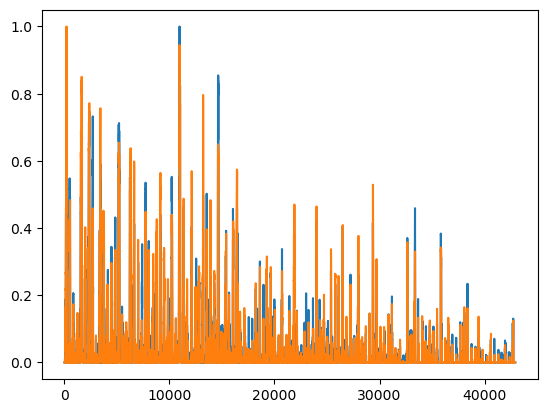

In [12]:
import matplotlib.pyplot as plt
for key in ds.keys():
    plt.plot(ds[key] / np.nanmax(ds[key]))

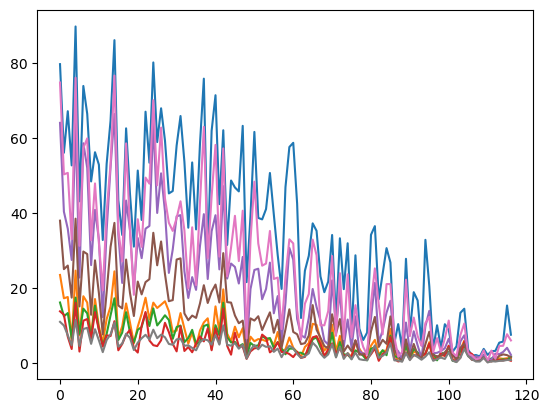

In [246]:
import xarray as xr

import hashlib
list_of_names = []
list_of_nums = []
for basin_name in np.unique(df.basin_name):
    tmp = df[df.basin_name == basin_name]
    tmpdate = [datetime.datetime(year = wyear, month = 4, day = 1) for wyear in tmp.wyear]
    tmp.loc[:, 'date'] = pd.DatetimeIndex(tmpdate)
    tmp.set_index('date', inplace= True)
    df_pivot = tmp.pivot(columns = 'pt', values = ['maxval_pt']) #', 'maxarg_pt', 'maxdate_pt'])
    df_pivot = df_pivot.reset_index()
    hash_object = hashlib.sha256(basin_name.encode())
    hash_int = int(hash_object.hexdigest(), 16)
    unique_number = int(hash_int % 100000000)
    list_of_nums.append(unique_number)
    i = 0
    cols = []
    for col in df_pivot.columns:
        cols.append('_'.join(map(str, [col[0], str(i)])))
        i += 1
    df_pivot.columns = cols
    df_pivot.index  =  pd.date_range(start='2000-01-01', periods = len(df_pivot), freq='D')
    df_pivot = df_pivot.rename_axis('date')
    maxdata = tmp.pivot(columns = 'pt', values = ['maxval_basin'])
    key = maxdata.columns[0]
    df_pivot.loc[:,'maxval_basin'] = maxdata[key].values
    df_pivot = df_pivot.drop('date_0', axis=1)
    nc_of = '/glade/u/home/mcowherd/nh-WRF/time_series/' + f'{unique_number}.nc'
    list_of_names.append(basin_name.replace(' ',''))
    ds = xr.Dataset.from_dataframe(df_pivot)
    # Save xarray Dataset to netCDF file
    ds.to_netcdf(nc_of)
    nn = basin_name.replace(' ','')
    nc_of = '/glade/u/home/mcowherd/nh-WRF/time_series/' + f'{nn}.nc'
    ds.to_netcdf(nc_of)
    

/glade/scratch/mcowherd/ipykernel_258832/447147062.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.loc[:, 'date'] = pd.DatetimeIndex(tmpdate)
/glade/scratch/mcowherd/ipykernel_258832/447147062.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp.loc[:, 'date'] = pd.DatetimeIndex(tmpdate)
/glade/scratch/mcowherd/ipykernel_258832/447147062.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [235]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Define number of rows and columns
N = 365 *3 
n_rows = N
n_cols = 3

# Generate random data for each column
sinusoidal_data = np.sin(np.linspace(0, 2*np.pi, n_rows))
linear_data = np.linspace(0, 1, n_rows)
normal_data = np.random.normal(size=n_rows)

# Create DataFrame
df = pd.DataFrame({'sinusoidal': sinusoidal_data, 'linear': linear_data, 'normal': normal_data})
df['date']  =  pd.date_range(start='2000-01-01', periods = N, freq='D')
df.set_index('date', inplace= True)
ds = xr.Dataset.from_dataframe(df)

ds.to_netcdf('/glade/u/home/mcowherd/nh-WRF/time_series/test.nc')


In [234]:
ds

<xarray.Dataset>
Dimensions:     (date: 730)
Coordinates:
  * date        (date) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-12-30
Data variables:
    sinusoidal  (date) float64 0.0 0.008619 0.01724 ... -0.008619 -2.449e-16
    linear      (date) float64 0.0 0.001372 0.002743 ... 0.9973 0.9986 1.0
    normal      (date) float64 0.4967 -0.1383 0.6477 ... 0.3476 -0.5398 -0.7783

In [162]:
df_pivot

,date,maxval_pt
pt,,ColeCanyon982
0,1981-04-01,1.565094
1,1982-04-01,2.347851
2,1983-04-01,1.186359
3,1984-04-01,1.092969
4,1985-04-01,2.171171
...,...,...
112,2093-04-01,1.754257
113,2094-04-01,0.562370
114,2095-04-01,0.495605


date
1981-04-01    10.999216
1982-04-01    10.015992
1983-04-01     7.419288
1984-04-01     4.721961
1985-04-01    11.538600
                ...    
2093-04-01     0.407252
2094-04-01     0.585005
2095-04-01     0.623353
2096-04-01     0.822406
2097-04-01     0.829968
Name: (maxval_basin, FishLake478), Length: 117, dtype: float64

In [145]:
df_pivot

,date_0,maxarg_pt_10,maxarg_pt_11,maxarg_pt_12,maxarg_pt_13,maxarg_pt_14,maxarg_pt_8,maxarg_pt_9,maxdate_pt_15,maxdate_pt_16,...,maxdate_pt_20,maxdate_pt_21,maxval_pt_1,maxval_pt_2,maxval_pt_3,maxval_pt_4,maxval_pt_5,maxval_pt_6,maxval_pt_7,maxval_basin
date,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00,1981-04-01,79.78822,23.520866,16.16879,13.810129,64.12019,38.009262,74.884254,186,175,...,175,186,1981-04-05,1981-03-25,1981-03-25,1981-03-24,1981-04-05,1981-03-25,1981-04-05,NaN
1971-01-01 05:49:12,1982-04-01,56.136753,17.292973,12.486586,12.903088,40.405293,25.06758,50.371967,181,155,...,155,180,1982-03-31,1982-03-05,1982-02-21,1982-02-20,1982-03-08,1982-03-05,1982-03-30,NaN
1972-01-01 11:38:24,1983-04-01,67.22805,17.631424,13.35023,7.029108,35.841877,26.02698,50.761677,174,113,...,114,174,1983-03-24,1983-01-22,1983-01-22,1983-01-22,1983-01-23,1983-01-23,1983-03-24,NaN
1972-12-31 17:27:36,1984-04-01,52.765453,5.943274,6.622274,3.747927,27.524126,17.46494,33.057827,200,122,...,122,123,1984-04-18,1984-01-31,1984-01-31,1984-01-31,1984-01-31,1984-01-31,1984-02-01,NaN
1973-12-31 23:16:48,1985-04-01,89.8457,24.67279,17.47238,16.115322,63.98158,38.54714,76.15005,195,174,...,158,195,1985-04-14,1985-03-24,1985-03-10,1985-03-05,1985-03-26,1985-03-08,1985-04-14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081-12-31 03:50:24,2093-04-01,3.255054,1.224923,1.027662,0.944243,2.509539,0.954221,1.155488,45,44,...,44,31,2092-11-15,2092-11-14,2092-11-14,2092-11-13,2092-11-14,2092-11-14,2092-11-01,NaN
2082-12-31 09:39:36,2094-04-01,5.448972,1.27639,0.814365,0.745666,2.363265,1.929907,4.563747,364,362,...,364,364,2094-09-30,2094-09-28,2094-09-28,2094-08-10,2094-09-30,2094-09-30,2094-09-30,NaN
2083-12-31 15:28:48,2095-04-01,5.741551,1.140213,1.012707,0.707176,2.967188,2.315231,4.61084,0,0,...,0,0,2094-10-01,2094-10-01,2095-07-11,2095-07-10,2094-10-01,2094-10-01,2094-10-01,NaN


In [144]:
ds

<xarray.Dataset>
Dimensions:        (date: 117)
Coordinates:
  * date           (date) datetime64[ns] 1970-01-01 ... 2085-12-31T03:07:12
Data variables: (12/23)
    date_0         (date) datetime64[ns] 1981-04-01 1982-04-01 ... 2097-04-01
    maxarg_pt_10   (date) object 79.78822 56.136753 ... 15.362842 7.5650415
    maxarg_pt_11   (date) object 23.520866 17.292973 ... 1.2935725 1.2457403
    maxarg_pt_12   (date) object 16.16879 12.486586 ... 0.88228333 1.699058
    maxarg_pt_13   (date) object 13.810129 12.903088 ... 0.97504187 0.61350787
    maxarg_pt_14   (date) object 64.12019 40.405293 ... 4.069516 2.1853278
    ...             ...
    maxval_pt_3    (date) object '1981-03-25' '1982-02-21' ... '2097-08-30'
    maxval_pt_4    (date) object '1981-03-24' '1982-02-20' ... '2097-08-30'
    maxval_pt_5    (date) object '1981-04-05' '1982-03-08' ... '2097-08-30'
    maxval_pt_6    (date) object '1981-03-25' '1982-03-05' ... '2097-08-30'
    maxval_pt_7    (date) object '1981-04-05' '1982-03-30' ... '2096-11-10'
    maxval_basin   (date) float64 nan nan nan nan nan ... nan nan nan nan nan

In [113]:
=

AttributeError: 'Dataset' object has no attribute 'rename_index'

In [105]:
ds

<xarray.Dataset>
Dimensions:          (index: 117)
Coordinates:
  * index            (index) datetime64[ns] 1970-01-01 1970-01-02 ... 1970-04-27
Data variables: (12/29)
    date_0           (index) datetime64[ns] 1981-04-01 1982-04-01 ... 2097-04-01
    maxval_pt_1      (index) object 79.78822 56.136753 ... 15.362842 7.5650415
    maxval_pt_2      (index) object 23.520866 17.292973 ... 1.2935725 1.2457403
    maxval_pt_3      (index) object 16.16879 12.486586 ... 0.88228333 1.699058
    maxval_pt_4      (index) object 13.810129 12.903088 ... 0.61350787
    maxval_pt_5      (index) object 64.12019 40.405293 ... 4.069516 2.1853278
    ...               ...
    maxval_basin_23  (index) object 10.999216 10.015992 ... 0.8224056 0.829968
    maxval_basin_24  (index) object 10.999216 10.015992 ... 0.8224056 0.829968
    maxval_basin_25  (index) object 10.999216 10.015992 ... 0.8224056 0.829968
    maxval_basin_26  (index) object 10.999216 10.015992 ... 0.8224056 0.829968
    maxval_basin_27  (index) object 10.999216 10.015992 ... 0.8224056 0.829968
    maxval_basin_28  (index) object 10.999216 10.015992 ... 0.8224056 0.829968

In [18]:
import pandas as pd

# Create a sample DataFrame
df = pd.DataFrame({'year': [2020, 2020, 2021, 2021], 'location': ['A', 'B', 'A', 'B'], 'value': [10, 20, 30, 40]})

# Pivot the DataFrame
df_pivot = df.pivot(index='year', columns='location', values='value')

# Reset the index of the pivoted DataFrame
df_pivot = df_pivot.reset_index()

# Rename the columns of the pivoted DataFrame
df_pivot.columns.name = None

# Check the pivoted DataFrame
print(df_pivot)

   year   A   B
0  2020  10  20
1  2021  30  40


In [11]:
import netCDF4
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
from shapely.geometry import Point

# Define the path to the netCDF files containing the snow depth and air temperature data
nc_path_snow = 'path/to/snow/netcdf/files/'
nc_path_temp = 'path/to/temperature/netcdf/files/'

# Define the list of latitude and longitude points
points_lat = [lat1, lat2, lat3, lat4, lat5, lat6, lat7]
points_lon = [lon1, lon2, lon3, lon4, lon5, lon6, lon7]

# Define the path to the shapefile containing the basins
shp_path = 'path/to/shapefile.shp'

# Load the shapefile as a GeoDataFrame
gdf = gpd.read_file(shp_path)

# Convert the latitude and longitude points to a GeoDataFrame
points = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lat, lon in zip(points_lat, points_lon)], crs=gdf.crs)

# Create an empty DataFrame to store the data
data = pd.DataFrame(columns=['snow_depth', 'temperature', 'basin_mean_snow_depth'])

# Loop over the basins in the shapefile
for index, row in gdf.iterrows():

    # Extract the bounding box of the basin
    bbox = row.geometry.bounds

    # Load the snow depth and air temperature netCDF files as xarray datasets
    ds_snow = xr.open_mfdataset(nc_path_snow + '*.nc')
    ds_temp = xr.open_mfdataset(nc_path_temp + '*.nc')

    # Extract the snow depth and air temperature values for the basin
    snow_depth = ds_snow.snow.sel(lon=slice(bbox[0], bbox[2]), lat=slice(bbox[3], bbox[1])).mean(dim=['lat', 'lon']).values
    temperature = ds_temp.temperature.sel(lon=slice(bbox[0], bbox[2]), lat=slice(bbox[3], bbox[1])).mean(dim=['lat', 'lon']).values

    # Extract the snow depth and air temperature values for the points within the basin
    points_snow_depth = ds_snow.snow.sel(lon=points_lon, lat=points_lat).values
    points_temperature = ds_temp.temperature.sel(lon=points_lon, lat=points_lat).values

    # Calculate the average snow depth for the basin
    basin_mean_snow_depth = snow_depth.mean()

    # Append the data to the DataFrame
    data = data.append(pd.DataFrame({'snow_depth': points_snow_depth, 'temperature': points_temperature, 'basin_mean_snow_depth': basin_mean_snow_depth}))

# Reset the index of the DataFrame
data.reset_index(drop=True, inplace=True)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Title: WRF data latitude and longitude coordinates
    Conventions: CF-1.7
    Institution: UCLA Center for Climate Science
    Source: https://dept.atmos.ucla.edu/alexhall/downscaling-cmip6
    dimensions(sizes): lat(340), lon(270)
    variables(dimensions): float32 lat2d(lat, lon), float32 lon2d(lat, lon)
    groups: 

In [ ]:
df

In [130]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the data into a pandas DataFrame
data = d

# Split the data into training and testing sets
train_data = data.sample(frac=0.8, random_state=1)
test_data = data.drop(train_data.index)

# Define the input and output variables
input_vars = ['station1', 'station2', 'station3'] # List of SNOTEL station snow water equivalent values
output_var = 'basin_swe' # Basin-wide snow water equivalent

# Simple models
# Model 1: All values are equivalent to the basin-wide value
y_train = np.array(train_data[output_var])
y_test = np.array(test_data[output_var])
y_pred = np.full((len(y_test)), y_train.mean())
print('Model 1 - All values are equivalent:')
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

# Model 2: Linear regression
X_train = train_data[input_vars].values.reshape((-1, len(input_vars)))
X_test = test_data[input_vars].values.reshape((-1, len(input_vars)))
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('Model 2 - Linear regression:')
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test


<xarray.Dataset>
Dimensions:        (date: 117)
Coordinates:
  * date           (date) datetime64[ns] 1970-01-01 1970-01-02 ... 1970-04-27
Data variables: (12/22)
    date_0         (date) datetime64[ns] 1981-04-01 1982-04-01 ... 2097-04-01
    maxarg_pt_10   (date) object 79.78822 56.136753 ... 15.362842 7.5650415
    maxarg_pt_11   (date) object 23.520866 17.292973 ... 1.2935725 1.2457403
    maxarg_pt_12   (date) object 16.16879 12.486586 ... 0.88228333 1.699058
    maxarg_pt_13   (date) object 13.810129 12.903088 ... 0.97504187 0.61350787
    maxarg_pt_14   (date) object 64.12019 40.405293 ... 4.069516 2.1853278
    ...             ...
    maxval_pt_2    (date) object '1981-03-25' '1982-03-05' ... '2097-08-13'
    maxval_pt_3    (date) object '1981-03-25' '1982-02-21' ... '2097-08-30'
    maxval_pt_4    (date) object '1981-03-24' '1982-02-20' ... '2097-08-30'
    maxval_pt_5    (date) object '1981-04-05' '1982-03-08' ... '2097-08-30'
    maxval_pt_6    (date) object '1981-03-25' '1982-03-05' ... '2097-08-30'
    maxval_pt_7    (date) object '1981-04-05' '1982-03-30' ... '2096-11-10'

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the data into a pandas DataFrame
data = pd.read_csv('snow_data.csv')

# Split the data into training and testing sets
train_data = data.sample(frac=0.8, random_state=1)
test_data = data.drop(train_data.index)

# Define the input and output variables
input_vars = ['station1', 'station2', 'station3'] # List of SNOTEL station snow water equivalent values
output_var = 'basin_swe' # Basin-wide snow water equivalent

# Simple models
# Model 1: All values are equivalent to the basin-wide value
y_train = np.array(train_data[output_var])
y_test = np.array(test_data[output_var])
y_pred = np.full((len(y_test)), y_train.mean())
print('Model 1 - All values are equivalent:')
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

# Model 2: Linear regression
X_train = train_data[input_vars].values.reshape((-1, len(input_vars)))
X_test = test_data[input_vars].values.reshape((-1, len(input_vars)))
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('Model 2 - Linear regression:')
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

# Complex models
# Model 3: K-Nearest Neighbors Regressor
knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print('Model 3 - K-Nearest Neighbors Regressor:')
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

# Model 4: Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print('Model 4 - Ridge Regression:')
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))

# Model 5: Lasso Regression
lasso = Lasso(alpha=1.0)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)


In [83]:
ds.rename(

<xarray.Dataset>
Dimensions:  (index: 117)
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 7 8 ... 109 110 111 112 113 114 115 116
Data variables: (12/22)
    0        (index) datetime64[ns] 1981-04-01 1982-04-01 ... 2097-04-01
    1        (index) object 79.78822 56.136753 67.22805 ... 15.362842 7.5650415
    2        (index) object 23.520866 17.292973 ... 1.2935725 1.2457403
    3        (index) object 16.16879 12.486586 13.35023 ... 0.88228333 1.699058
    4        (index) object 13.810129 12.903088 ... 0.97504187 0.61350787
    5        (index) object 64.12019 40.405293 35.841877 ... 4.069516 2.1853278
    ...       ...
    1_6      (index) object '1981-03-25' '1982-03-05' ... '2097-08-13'
    1_7      (index) object '1981-03-25' '1982-02-21' ... '2097-08-30'
    1_8      (index) object '1981-03-24' '1982-02-20' ... '2097-08-30'
    1_9      (index) object '1981-04-05' '1982-03-08' ... '2097-08-30'
    2_0      (index) object '1981-03-25' '1982-03-05' ... '2097-08-30'
    2_1      (index) object '1981-04-05' '1982-03-30' ... '2096-11-10'